<a href="https://colab.research.google.com/github/medalidia/apprentissage_git/blob/main/projet_polarite_avis_clients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Projet NLP ‚Äì Classification de la polarit√© des avis clients
**Auteur : Mohamed Ali Dia**  
**Date : Juillet 2025**  

Ce projet a pour objectif de d√©velopper un syst√®me automatique permettant de classifier un avis client en ligne comme **positif** ou **n√©gatif**, en utilisant un jeu de donn√©es d‚Äôavis en fran√ßais.  
Nous allons passer par les √©tapes suivantes :

- Pr√©traitement des textes (nettoyage, lemmatisation)
- Analyse exploratoire
- Vectorisation des textes (TF-IDF)
- Entra√Ænement de plusieurs mod√®les de classification
- √âvaluation comparative
- Sauvegarde des mod√®les


## 1. Importation des biblioth√®ques

In [8]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
import joblib
import spacy
from wordcloud import WordCloud
from collections import Counter
import itertools

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    ConfusionMatrixDisplay,
    f1_score
)


## 2. Pr√©paration des outils linguistiques

In [9]:

nltk.download('stopwords')
stop_words = set(stopwords.words('french'))

# Chargement du mod√®le SpaCy fran√ßais avec gestion d‚Äôerreur
import subprocess
try:
    nlp = spacy.load("fr_core_news_sm")
except:
    subprocess.run(["python", "-m", "spacy", "download", "fr_core_news_sm"])
    nlp = spacy.load("fr_core_news_sm")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 3. Chargement du jeu de donn√©es

In [10]:
splits = {'train': 'allocine/train-00000-of-00001.parquet', 'validation': 'allocine/validation-00000-of-00001.parquet', 'test': 'allocine/test-00000-of-00001.parquet'}
df = pd.read_parquet("hf://datasets/tblard/allocine/" + splits["train"])
from datasets import load_dataset


# R√©duire √† un √©chantillon pour limiter le temps d'ex√©cution
df = df.sample(10000, random_state=42)

# Garder uniquement les colonnes utiles
df = df[['review', 'label']]

# Affichage des premi√®res lignes
print(df.head())

                                                   review  label
120476  Un excellent thriller d'action o√π les sc√®nes d...      1
32693   Si le sc√©nariste, qui aurait pu faire un minim...      0
79958   R√©f√©rence dans la filmographie de Bogart, "Le ...      0
76366   Un bon sc√©nario, un bon film, une histoire lou...      1
82343   Un scenario vide et une mise en scene tr√©s sop...      0


## 4. Nettoyage et lemmatisation des textes

In [11]:

def clean_and_lemmatize(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc
              if token.lemma_.lower() not in stop_words and token.is_alpha and len(token) > 2]
    return " ".join(tokens)

df['clean_review'] = df['review'].apply(clean_and_lemmatize)
df[['review', 'clean_review']].head()


review  \
120476  Un excellent thriller d'action o√π les sc√®nes d...   
32693   Si le sc√©nariste, qui aurait pu faire un minim...   
79958   R√©f√©rence dans la filmographie de Bogart, "Le ...   
76366   Un bon sc√©nario, un bon film, une histoire lou...   
82343   Un scenario vide et une mise en scene tr√©s sop...   

                                             clean_review  
120476  excellent thriller daction sc√®ne bravoure croi...  
32693   sc√©nariste avoir faire minimum recherche √©vite...  
79958   r√©f√©rence filmographie bogart violent nen rest...  
76366   bon sc√©nario bon film histoire loufoque t√©n√©br...  
82343   scenario vide mise scene trer soporifique fill...

## 5. Exploration des donn√©es (r√©partition des classes)

label
1    5096
0    4904
Name: count, dtype: int64


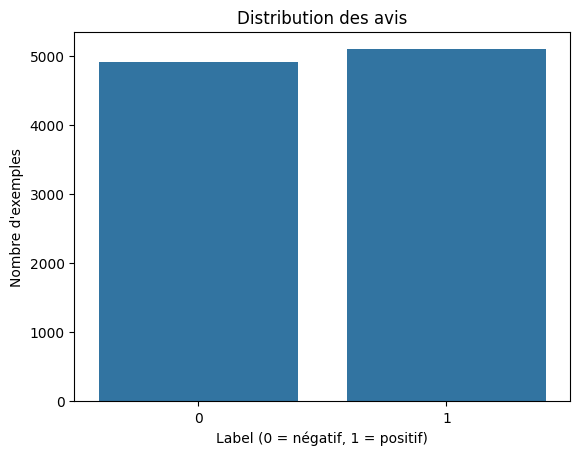

In [12]:

print(df['label'].value_counts())

sns.countplot(x='label', data=df)
plt.title("Distribution des avis")
plt.xlabel("Label (0 = n√©gatif, 1 = positif)")
plt.ylabel("Nombre d'exemples")
plt.show()


## 6. Visualisation des mots les plus fr√©quents

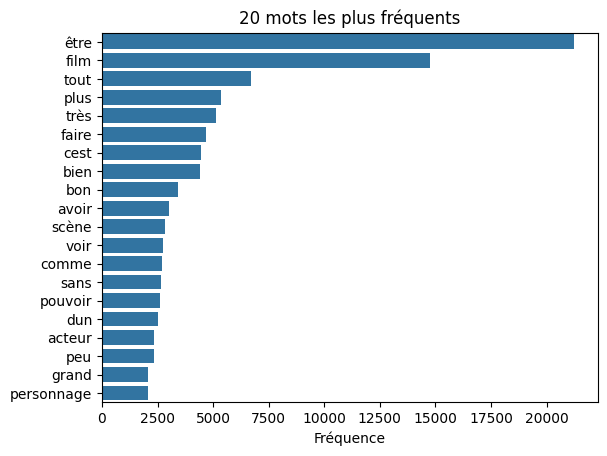

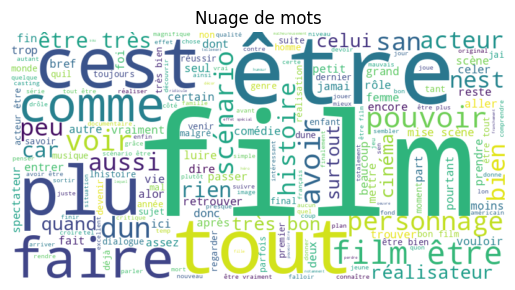

In [13]:

all_words = list(itertools.chain(*df['clean_review'].str.split()))
word_freq = Counter(all_words).most_common(20)
words, counts = zip(*word_freq)

sns.barplot(x=counts, y=words)
plt.title("20 mots les plus fr√©quents")
plt.xlabel("Fr√©quence")
plt.show()

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(all_words))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Nuage de mots")
plt.show()


## 7. Vectorisation des textes (TF-IDF)

In [14]:

vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X = vectorizer.fit_transform(df['clean_review'])
y = df['label']


## 8. S√©paration des donn√©es d'entra√Ænement et de test

In [15]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## 9. Entra√Ænement des mod√®les de classification

In [16]:

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

svm_model = LinearSVC()
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)


## 10. √âvaluation des mod√®les

=== R√©gression Logistique ===
[[865 110]
 [104 921]]
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       975
           1       0.89      0.90      0.90      1025

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000

Accuracy: 0.893


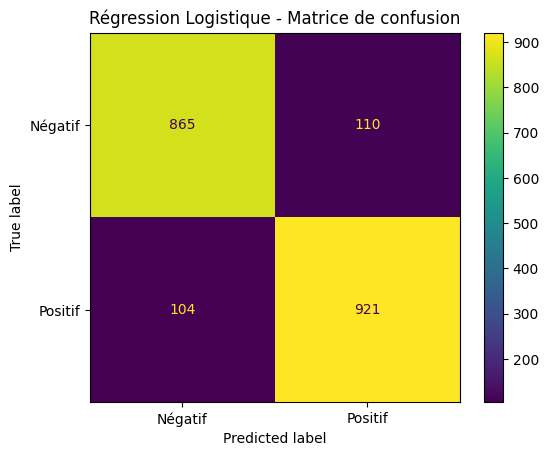

=== SVM Lin√©aire ===
[[862 113]
 [110 915]]
              precision    recall  f1-score   support

           0       0.89      0.88      0.89       975
           1       0.89      0.89      0.89      1025

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000

Accuracy: 0.8885


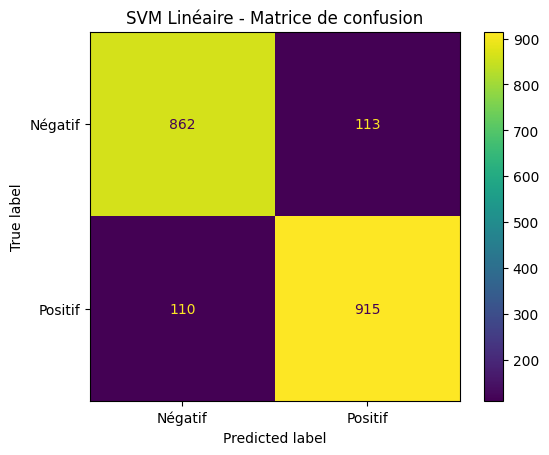

=== Random Forest ===
[[841 134]
 [167 858]]
              precision    recall  f1-score   support

           0       0.83      0.86      0.85       975
           1       0.86      0.84      0.85      1025

    accuracy                           0.85      2000
   macro avg       0.85      0.85      0.85      2000
weighted avg       0.85      0.85      0.85      2000

Accuracy: 0.8495


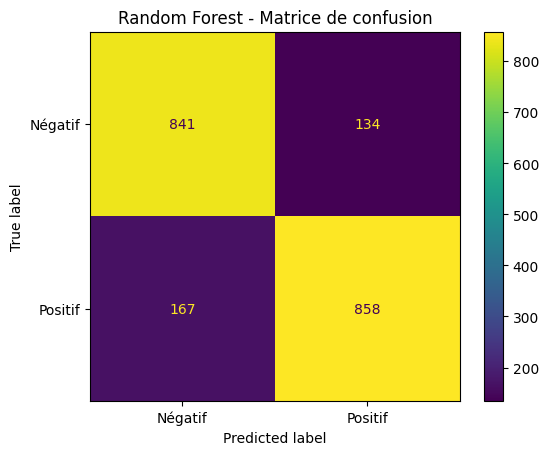

In [17]:

def eval_model(name, y_true, y_pred):
    print(f"=== {name} ===")
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred))
    print("Accuracy:", accuracy_score(y_true, y_pred))
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=["N√©gatif", "Positif"])
    plt.title(f"{name} - Matrice de confusion")
    plt.show()

eval_model("R√©gression Logistique", y_test, y_pred_lr)
eval_model("SVM Lin√©aire", y_test, y_pred_svm)
eval_model("Random Forest", y_test, y_pred_rf)


### üîç F1-score pond√©r√© (compl√©ment d'√©valuation)

In [18]:

print("F1-score pond√©r√© - Logistic Regression :", f1_score(y_test, y_pred_lr, average="weighted"))
print("F1-score pond√©r√© - SVM :", f1_score(y_test, y_pred_svm, average="weighted"))
print("F1-score pond√©r√© - Random Forest :", f1_score(y_test, y_pred_rf, average="weighted"))


F1-score pond√©r√© - Logistic Regression : 0.8929910049478792
F1-score pond√©r√© - SVM : 0.888495564760353
F1-score pond√©r√© - Random Forest : 0.849521109150136


## 11. Comparaison des performances des mod√®les

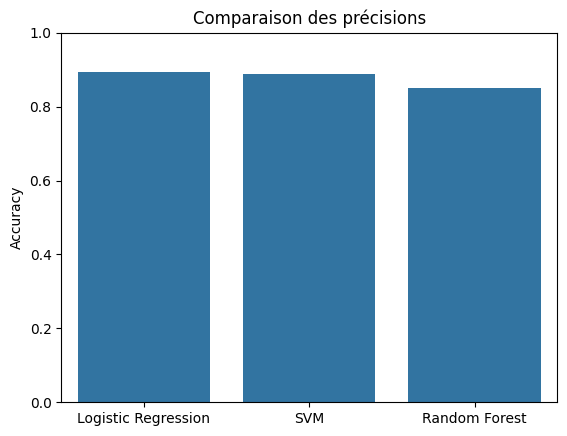

In [19]:

models = ['Logistic Regression', 'SVM', 'Random Forest']
accuracies = [
    accuracy_score(y_test, y_pred_lr),
    accuracy_score(y_test, y_pred_svm),
    accuracy_score(y_test, y_pred_rf)
]

sns.barplot(x=models, y=accuracies)
plt.title("Comparaison des pr√©cisions")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()


## 12. √âchantillon de pr√©dictions

In [20]:

indices = y_test.iloc[:5].index
sample_preds = pd.DataFrame({
    "Review": df.loc[indices, 'review'].values,
    "Label r√©el": y_test.loc[indices].values,
    "Pr√©diction LR": y_pred_lr[:5],
    "Pr√©diction SVM": y_pred_svm[:5],
    "Pr√©diction RF": y_pred_rf[:5]
})
sample_preds


Review  Label r√©el  \
0  l'id√©e de la possession ou du d√©doublement de ...           0   
1  Tr√®s bonne com√©die dramatique, co√©crite et sc√©...           1   
2  M√™me si l'on sent un v√©ritable engagement de P...           0   
3  Son premier film, un court m√©trage, il l'a r√©a...           0   
4  On sait en allant voir ce film qu'on ne pourra...           0   

   Pr√©diction LR  Pr√©diction SVM  Pr√©diction RF  
0              0               0              0  
1              1               1              1  
2              0               0              0  
3              0               0              0  
4              0               0              0

## 13. Sauvegarde des mod√®les entra√Æn√©s

In [21]:

joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
joblib.dump(lr_model, "logistic_model.pkl")
joblib.dump(svm_model, "svm_model.pkl")
joblib.dump(rf_model, "random_forest_model.pkl")

pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('clf', LogisticRegression(max_iter=1000))
])
pipeline_lr.fit(df['clean_review'], df['label'])
joblib.dump(pipeline_lr, "pipeline_logistic.pkl")

print("Tous les mod√®les ont √©t√© sauvegard√©s avec succ√®s.")


Tous les mod√®les ont √©t√© sauvegard√©s avec succ√®s.
